# Determine the offset values

Using the frames where the plasma is expected to be at the centroid, the relationship between the offset value in each probe array and plasma current is determined

## approximate frames at centroid

In [5]:
import cv2
import shutil
from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity
from tqdm import tqdm

retreive_img_directory = lambda shot_no: f"resources\\TTI frame\\{shot_no}\\{shot_no}_frames_jpg\\"
centroid_directory = r"resources\\centroidFrames"

img_directory =  retreive_img_directory(966)

all_shot_no = [370,433,582,665,920,926,928] + list(range(960,971)) + [1108,1275,1745,1804,2308]
base_frame_dict = {
    433:187, 582:160, 665:189, 926:160, 960:155, 961:192, 962:199, 963:155, 964: 154, 965: 200, 966:200, 967:208, 968:154,969:205,
    970:209,1108:184,1275:184,1745:181,1804:189,2308:198
}

In [ ]:
similarity = []
for shot_no in all_shot_no:
    if shot_no in [370,920,928]:continue

    img_directory = retreive_img_directory(shot_no)
    for i in [-1,0,1]:
        frame = base_frame_dict[shot_no] + i
        img_path = img_directory + f"{frame}.jpg"
        shutil.copy(img_path,centroid_directory + f"\\{shot_no}_{frame}.jpg")

## Calculate offset for each frame

In [6]:
from toroidalFilament_dir.geometry_TT1 import all_arrays, coil_angle_dict, probe_lst_to_str
from toroidalFilament_dir.DxDz import cal_newton_DxDz as cal_DxDz
from toroidalFilament_dir.signal_strength import cal_signal
from process_probe_data import retreive_plasma_current,retreive_magnetic_signal, trim_quantities, discharge_duration

import numpy as np
import os
import pandas as pd

Ip_df = pd.read_excel(os.getcwd() + r"\resources\magneticSignal\Plasma current for plasma position.xlsx",sheet_name="Sheet1")
probe_signal_path = os.getcwd() + r"\resources\magneticSignal\Magnetic probe GBP_T for plasma position.xlsx"


In [7]:
x_shift, z_shift = 0,0

center_Dx = []
for probe_arr in all_arrays:
    probe_angles = [coil_angle_dict[probe] for probe in probe_arr]
    signal = cal_signal(x_shift,z_shift,probe_angles)
    Dx, Dz = cal_DxDz(signal,probe_angles)
    center_Dx.append(Dx)

mean_Dx_offset = np.mean(center_Dx)

print("mean value of Dx at centroid is" + f" {mean_Dx_offset} m")

mean value of Dx at centroid is -0.204920003280666 m


In [8]:
def find_closest(arr, target): #use binary search to find element with closest value to the target
    res = arr[0]
    lo = 0
    hi = len(arr) - 1

    while lo <= hi:
        mid = lo + (hi - lo) // 2

        # Update res if mid is closer to target
        if abs(arr[mid] - target) < abs(res - target):
            res = arr[mid]

        # In case of a tie, prefer larger value
        elif abs(arr[mid] - target) == abs(res - target):
            res = max(res, arr[mid])

        if arr[mid] == target:
            return arr[mid]
        elif arr[mid] < target:
            lo = mid + 1
        else:
            hi = mid - 1

    return res

In [9]:
# Precompute keys and angles
probe_keys = [probe_lst_to_str(arr) for arr in all_arrays]
probe_angles = {
    probe_lst_to_str(arr): [coil_angle_dict[p] for p in arr]
    for arr in all_arrays
}

offset_dict = {
    key: [[], []] for key in probe_keys
}

# Cache for Excel files and column indices
excel_cache = {}  # shot_no -> DataFrame
column_index_cache = {}  # (shot_no, probe_key) -> list of indices

def time_from_frame(frame):
    time = frame / 2 + 260 
    return find_closest(Ip_df["Time [ms]"], time)

def find_Ip(shot_no, time):
    row = Ip_df.loc[Ip_df["Time [ms]"] == time].index[0]
    col = Ip_df.columns.get_loc(shot_no)
    return Ip_df.iloc[row, col]

def get_signal_df(shot_no):
    if shot_no not in excel_cache:
        #retrieve signal and plasma current to remove noise
        signal_df = pd.read_excel(probe_signal_path, sheet_name=f"shot_{shot_no}")
        Ip_df,time_df,t1, t2 = retreive_plasma_current(shot_no)
        time_df,_, trimmed_signal_df = trim_quantities(time_df,signal_df,Ip_df,t1,t2)
        excel_cache[shot_no] = [time_df,trimmed_signal_df]

    return excel_cache[shot_no]

def find_signal(shot_no, time, probe_arr, probe_key):
    time_df, signal_df = get_signal_df(shot_no)

    if (shot_no, probe_key) not in column_index_cache:
        use_columns = [f"GBP{i}T" for i in probe_arr]
        column_index_cache[(shot_no, probe_key)] = [
            signal_df.columns.get_loc(col) for col in use_columns
        ]


    col_indices = column_index_cache[(shot_no, probe_key)]
    row = time_df[time_df == time].index[0]
    row = time_df.index.get_loc(row)

    return [signal_df.iloc[row, col] for col in col_indices]

def cal_offset(Dx, Dx0=mean_Dx_offset):
    return Dx0 - Dx

shot_no_from_path = lambda path: int(''.join(filter(str.isdigit, path[0:4])))
frame_from_path = lambda path: int(path[-7:-4])

for img_path in tqdm(os.listdir(r"resources\centroidFrames")):
    try:
        shot_no = shot_no_from_path(img_path)

        #retrieve frame number from the file name
        frame = frame_from_path(img_path)

        #find plasma current at time of frame
        time = time_from_frame(frame)
        Ip = find_Ip(shot_no, time)

        for probe_arr in all_arrays:
            probe_key = probe_lst_to_str(probe_arr)
            signal = find_signal(shot_no, time, probe_arr, probe_key)

            angles = probe_angles[probe_key]
            Dx, Dz = cal_DxDz(signal, c_angle=angles)
            offset_Dx = cal_offset(Dx)

            offset_dict[probe_key][0].append(Ip)
            offset_dict[probe_key][1].append(offset_Dx)
    except KeyError:
        continue

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [03:06<00:00,  3.11s/it]


Text(0.5, 1.0, 'Dx offset as a function of Ip')

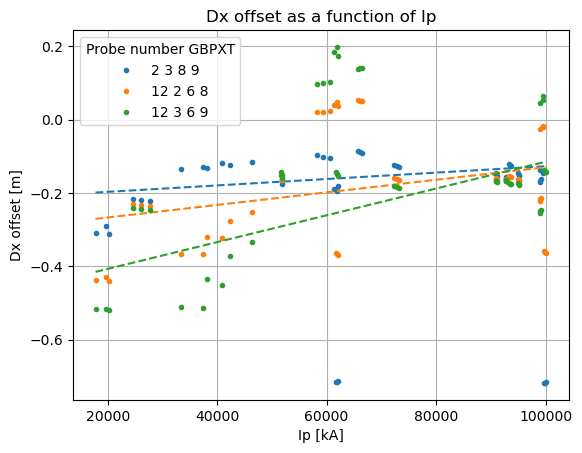

In [41]:
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression

for key in offset_dict:
    Ip_list, offset_list = offset_dict[key]
    if Ip_list:  # only sort if not empty
        sorted_pairs = sorted(zip(Ip_list, offset_list))
        offset_dict[key][0], offset_dict[key][1] = map(list, zip(*sorted_pairs))

for key in [probe_lst_to_str(probe_arr) for probe_arr in [[2,3,8,9],[12,2,6,8],[12,3,6,9]]]:
    Ip_list = offset_dict[key][0]
    offset_list = offset_dict[key][1]
    
    if len(Ip_list) >= 2:
        # Convert to numpy arrays and reshape for sklearn
        X = np.array(Ip_list).reshape(-1, 1)
        y = np.array(offset_list)

        # Create RANSAC regressor
        ransac = RANSACRegressor(LinearRegression(), residual_threshold=0.3, random_state=0)
        ransac.fit(X, y)

        # Predict with inlier model
        x_vals = np.linspace(min(Ip_list), max(Ip_list), 100).reshape(-1, 1)
        y_fit = ransac.predict(x_vals)

        # Plot original data
        data_line, = plt.plot(Ip_list, offset_list, ".", label=f"{key}")
        color = data_line.get_color()

        # Plot RANSAC regression line
        plt.plot(x_vals, y_fit, "--", color=color)

        plt.title(f"Key: {key}")
        plt.xlabel("Ip [kA]")
        plt.ylabel("Dx offset [m]")
        plt.grid(True)

plt.legend(title = "Probe number GBPXT")
plt.title("Dx offset as a function of Ip")
# plt.ylim(-2,2)